# Imports

In [1]:
# Standard libraries
import random
from collections import Counter

# External libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "./dataset/complete_dataset"

##  Name of classes 
CLASSES = ['glioma',
           'meningioma',
           'no_tumor',
           'pituitary']

In [7]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(176, 208),batch_size=10183, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 10183 images belonging to 4 classes.


In [8]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (10183, 176, 208, 3)
Labels shape :	 (10183, 4)


In [9]:
#   Number of samples in classes 
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 2547), (1, 2582), (2, 2396), (3, 2658)]
Classes Names according to index:	 {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


# Random samples from dataset

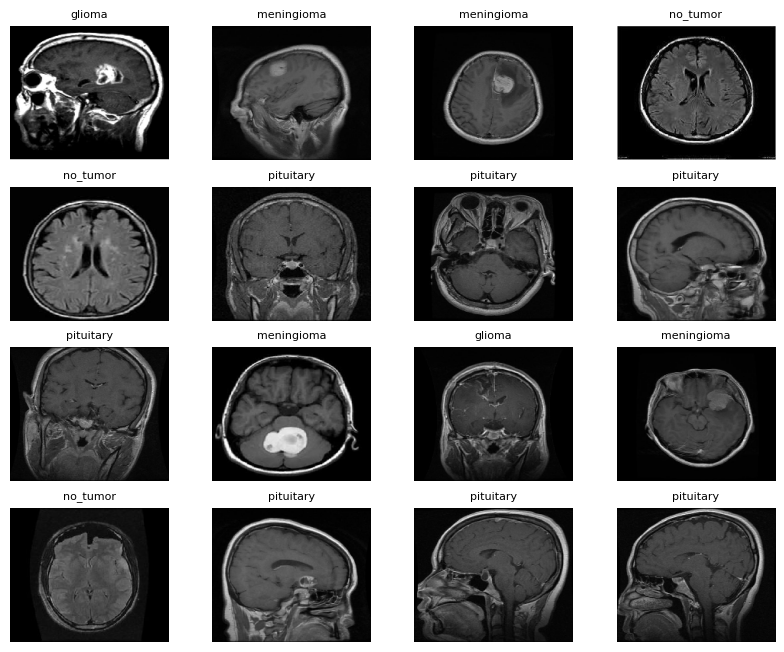

In [10]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()